# 0.0 IMPORTS 

In [1]:
import numpy as np
import math
import pandas as pd
import inflection
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime
from boruta import BorutaPy
import xgboost as xgb
import random
import warnings
warnings.filterwarnings('ignore')
import pickle

from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from IPython.display import Image


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\55149\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\55149\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\55149\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\55149\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch

AttributeError: _ARRAY_API not found

## FUNÇÕES

In [2]:
def cross_validation(x_training,kfold,model_name, model,verbose=False):
    mae_list=[]
    mape_list=[]
    rmse_list=[]
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #start end date for validation
        validation_start_date=x_training['date'].max()-datetime.timedelta(days=k*6*7)
        validation_end_date=x_training['date'].max()-datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training=x_training[x_training['date']<validation_start_date]
        validation=x_training[(x_training['date']>=validation_start_date) & (x_training['date']<=validation_end_date)] 

        #training and validation dataset
        #traing
        xtraining=training.drop(['date','sales'], axis=1)
        ytraining=training['sales']

        #validation
        xvalidation=validation.drop(['date', 'sales'], axis=1)
        yvalidation=validation['sales']

        #model
        m=model.fit(xtraining, ytraining)

        #prediction
        yhat=m.predict(xvalidation)
        #perfomance
        m_result=ml_error(model_name, np.expm1(yvalidation),np.expm1(yhat))
        
        #store perfomance of each kfold interation
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'MODEL NAME': model_name,
                        'MAE CV': np.round(np.mean(mae_list),2).astype(str)+ '+/-' + np.round(np.std(mae_list),2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list),2).astype(str)+ '+/-' + np.round(np.std(mape_list),2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str)+ '+/-' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

## LOADING DATA 

In [3]:
df_sales_raw=pd.read_csv(r"C:\Users\55149\OneDrive - Fatec Centro Paula Souza\Documents\repos\ds_producao\train.csv", low_memory=False)
df_store_raw=pd.read_csv(r"C:\Users\55149\OneDrive - Fatec Centro Paula Souza\Documents\repos\ds_producao\store.csv", low_memory=False)

#merge
df_raw=pd.merge(df_sales_raw, df_store_raw, how='left', on ='Store')

# 1.0 PASSO 01 - DESCRICAO DE DADOS 

In [4]:
df1=df_raw.copy()

## RENAME COLUMNS

In [5]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase= lambda x: inflection.underscore(x)

cols_new=list(map(snakecase,cols_old))

#rename

df1.columns=cols_new

## 1.2. DATA DIMENSIONS 

In [6]:
print('number of rows: {}'.format(df1.shape[0]))
print('number of cols: {}'.format(df1.shape[1]))

number of rows: 1017209
number of cols: 18


## 1.3.DATA TYPES

In [7]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. FILLOUT NA 

In [8]:
#competition_distance
df1['competition_distance']=df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month 
df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

                              
#promo2_since_week
df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval 
month_map={1:'Jan', 2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)
df1['month_map']=df1['date'].dt.month.map(month_map)

df1['is_promo']=df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.5.  CHANGE TYPES

In [9]:
df1['competition_open_since_month']=df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']=df1['competition_open_since_year'].astype(int)

df1['promo2_since_week']=df1['promo2_since_week'].astype(int)
df1['promo2_since_year']=df1['promo2_since_year'].astype(int)

## 1.6. DESCRIPTIVE STATISCAL

In [10]:
atributo_num=df1.select_dtypes(include=['int64','float64','int32'])
atributo_cat=df1.select_dtypes(exclude=['int64','int32','float64','datetime64[ns]'])

## 1.6.1. NUMERICAL ATTRIBUTES

In [11]:
#tendencia central- média, mediana 
ct1=pd.DataFrame(atributo_num.apply(np.mean)).T
ct2=pd.DataFrame(atributo_num.apply(np.median)).T


#dispersão- desvio padrão, min, max, range, skew, kurtosis
d1=pd.DataFrame(atributo_num.apply(np.std)).T
d2=pd.DataFrame(atributo_num.apply(min)).T
d3=pd.DataFrame(atributo_num.apply(max)).T
d4=pd.DataFrame(atributo_num.apply(lambda x: x.max()-x.min())).T
d5=pd.DataFrame(atributo_num.apply(lambda x: x.skew())).T
d6=pd.DataFrame(atributo_num.apply(lambda x: x.kurtosis())).T

# concatenate

m=pd.concat([d2,d3,d4,ct2,ct2,d1,d5,d6]).T.reset_index()
m.columns=['atributos','min','max','range','média','mediana','std','skew','kurtosis']

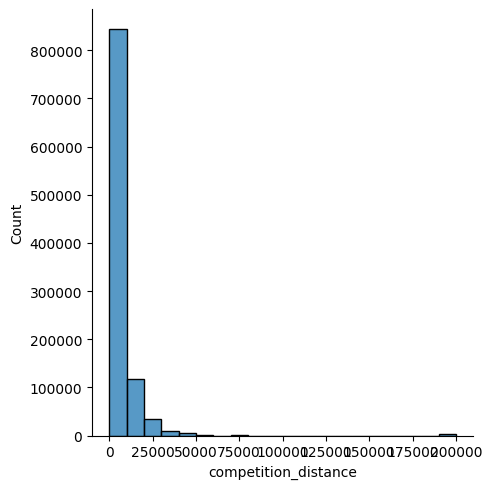

In [12]:
sns.displot(df1['competition_distance'],bins=20)

## ATRIBUTOS CATEGÓRICOS

In [13]:
atributo_cat.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

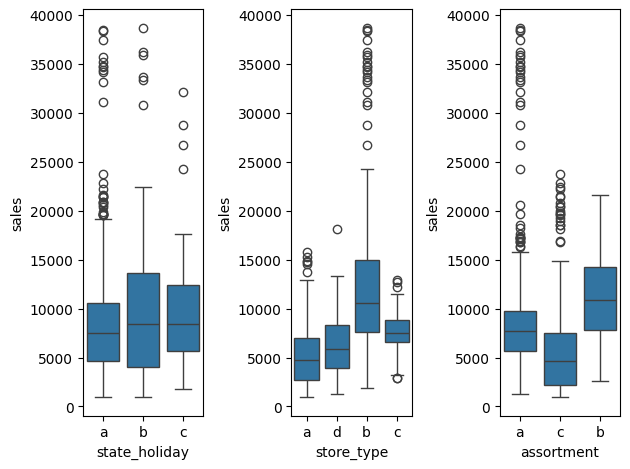

In [14]:
aux1=df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1 )

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1 )

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1 )

plt.tight_layout()
plt.show()

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [15]:
df2=df1.copy()

## 2.1.MAPA MENTAL DE HIPOTESES 

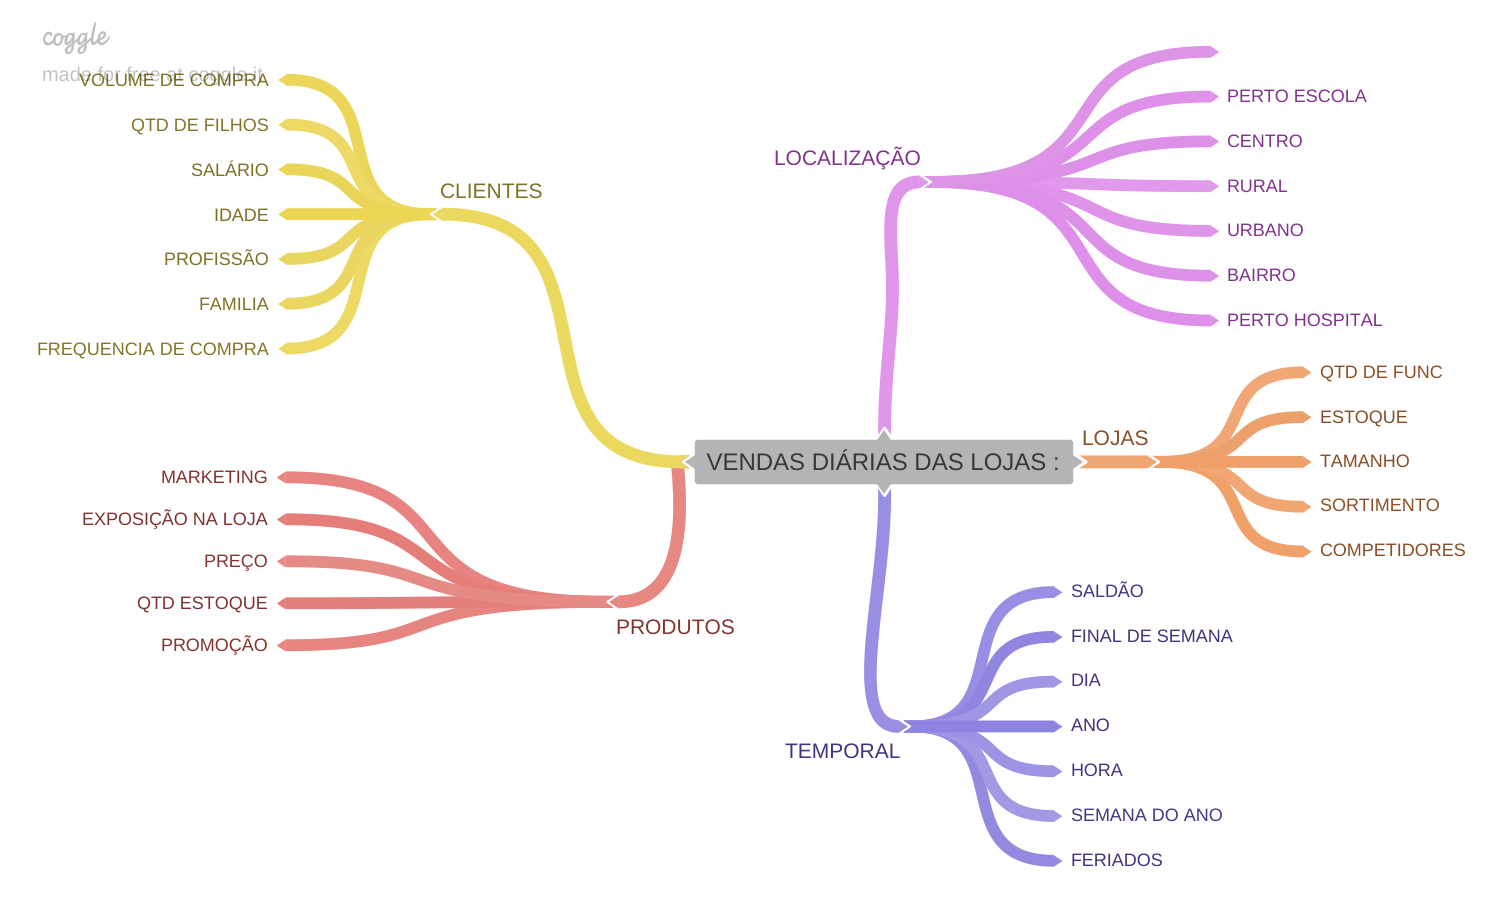

In [16]:
Image(r"C:\Users\55149\OneDrive - Fatec Centro Paula Souza\Documents\repos\ds_producao\img\MindMapHypothesis.png")

## 2.1. CRIAÇÃO DE HIPOTESES 

### 2.1.1. HIPOTESE LOJA 

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2. HIPOTESE PRODUTO 

**1.** lojas que investem mais em marketing deveriam vender mais.

**2.** lojas que expoem produtos mais deveriam vender mais.

**3.** lojas que tem preços menores deveriam vender mais.

**4.** lojas com promoções mais agressivas deveriam vender mais.

**5.** lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** lojas com mais dias de promoção deveriam vender mais.

**7.** lojas com mais promoções conseuctivas deveriam vender mais.

### 2.1.3. HIPOTESE TEMPO

**1.** lojas abertas durante o feriado de natal deveriam vender mais.

**2.** lojas deveriam vender mais ao longos dos anos.

**3.** lojas deveriam vender mais no segundo semestre do ano.
    
**4.** lojas deveriam vender mais depois do dia 10 de cada mês.
    
**5.** lojas deveriam vender menos aos finais de semana.
    
**6.** Lojas deveriam vender menos durante os feriados escolares .

## 2.2. LISTA FINAL DE HIPOTESES 

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais

**1.** lojas com promoções ativas por mais tempo deveriam vender mais.

**2.** lojas com mais dias de promoção deveriam vender mais.

**3.** lojas com mais promoções conseuctivas deveriam vender mais.

**1.** lojas abertas durante o feriado de natal deveriam vender mais.

**2.** lojas deveriam vender mais ao longos dos anos.

**3.** lojas deveriam vender mais no segundo semestre do ano.
    
**4.** lojas deveriam vender mais depois do dia 10 de cada mês.
    
**5.** lojas deveriam vender menos aos finais de semana.
    
**6.** Lojas deveriam vender menos durante os feriados escolares .

## 2.3. FEATURE ENGINEERING

In [17]:
#year
df2['year']=df2['date'].dt.year

#month
df2['month']=df2['date'].dt.month

#day 
df2['day']=df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week 
df2['year_week']=df2['date'].dt.strftime('%Y-%W')

#competition since 
df2['competition_since']=df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(lambda x:x.days).astype(int)

# promo since 
df2['promo_since']=df2['promo2_since_year'].astype(str)+'-' + df2['promo2_since_week'].astype(str)

df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w')-datetime.timedelta(days=7))

df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment']=df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')


#state holiday 
df2['state_holiday']=df2['state_holiday'].apply (lambda x: 'public_holiday' if x=='a' else 'Easter holiday' if x=='b' else 'Christmas' if x=='c' else 'regular_day')

# 3.0 PASSO 03 - FILTRAGEM DE VARIAVÉIS 

In [18]:
df3=df2.copy()

## 3.1. FILTRAGEM DAS LINHAS 

In [19]:
df3=df3[(df3['open']!=0 ) & (df3['sales'] >0)]

## 3.2. SELEÇÃO DAS COLUNAS 

In [20]:
cols_drop = ['customers','open','promo_interval', 'month_map']
df3=df3.drop(cols_drop, axis=1)

In [21]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 PASSO 04- ANALISE EXPLORATORIA DOS DADOS 

In [22]:
df4=df3.copy()

In [23]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1. ANALISE UNIVARIADA 


### 4.1.1. VARIAVEL RESPOSTA

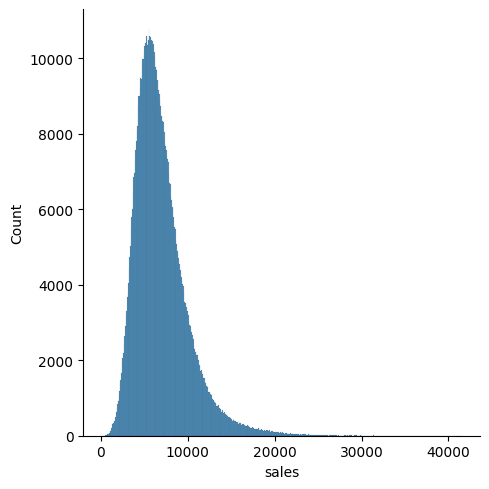

In [24]:
sns.displot(df4['sales'], kde=False)

### 4.1.2. VARIAVEL NUMERICA

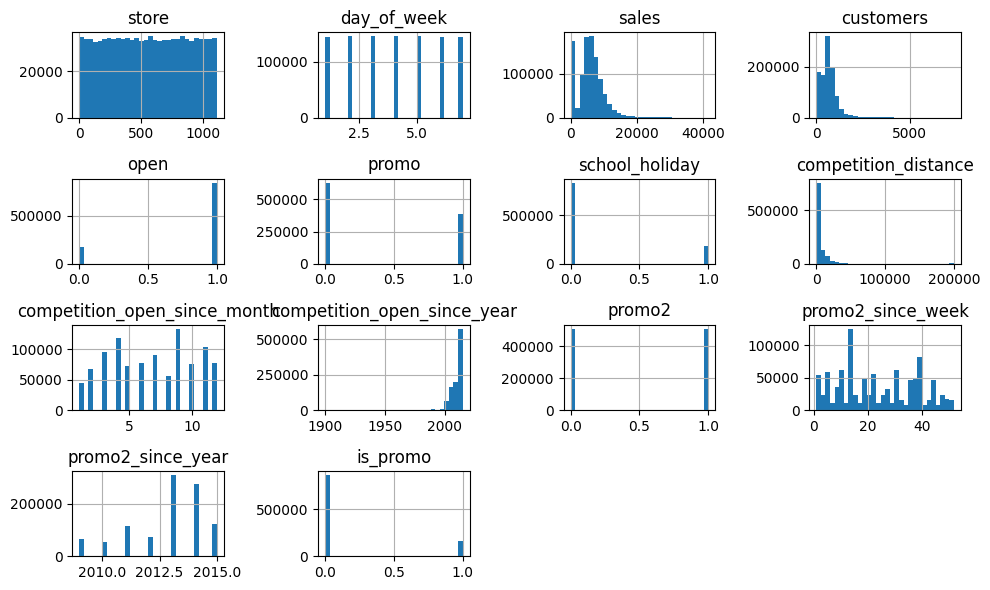

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
atributo_num.hist(bins=30, ax=ax)

ax.set_title('Título do Gráfico')
ax.set_xlabel('Nome do Eixo X')
ax.set_ylabel('Nome do Eixo Y')

plt.tight_layout()
plt.show()

### 4.1.3. VARIAVEL CATEGORICA

In [26]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

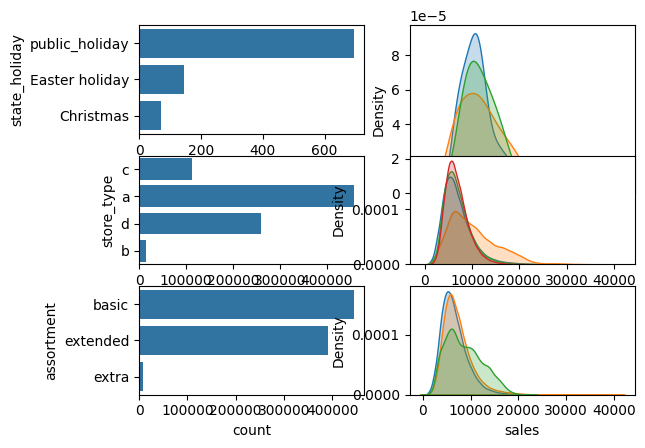

In [27]:
#state_holiday
plt.subplot(3,2,1)
a=df4[df4['state_holiday']!='regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(2,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label="public_holiday", fill=True )
sns.kdeplot(df4[df4['state_holiday']=='Easter holiday']['sales'],label="Easter holiday", fill=True )
sns.kdeplot(df4[df4['state_holiday']=='Christmas']['sales'],label="Christmas", fill=True )

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label="a", fill=True )
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label="b", fill=True )
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label="c", fill=True )
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label="d", fill=True )

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label="basic", fill=True )
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label="extended", fill=True )
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label="extra", fill=True )

## 4.2. ANALISE BIVARIADA 

### **1.** Lojas com maior sortimento deveriam vender mais.

**FALSA**

<Axes: xlabel='year_week'>

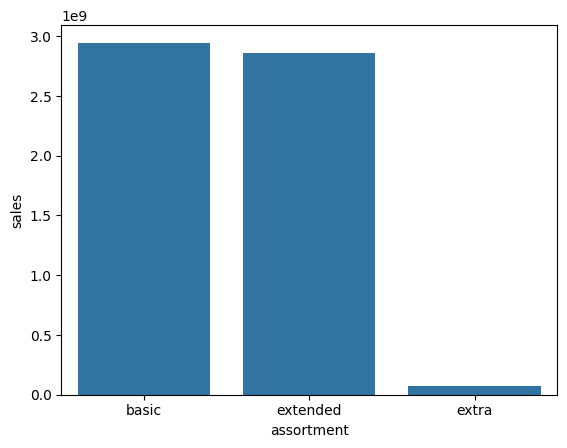

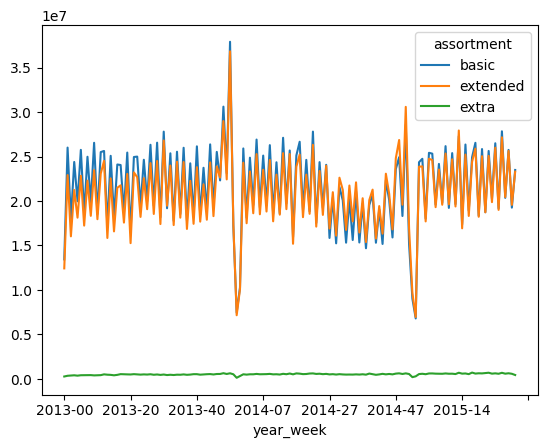

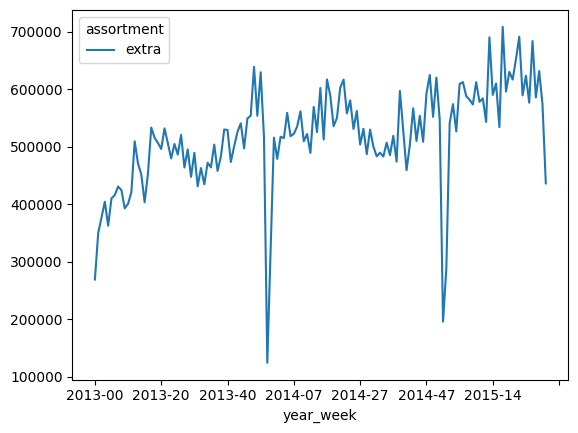

In [28]:
aux1=df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales',data=aux1);

aux2=df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3=aux2[aux2['assortment']== 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()  

### **2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSA**

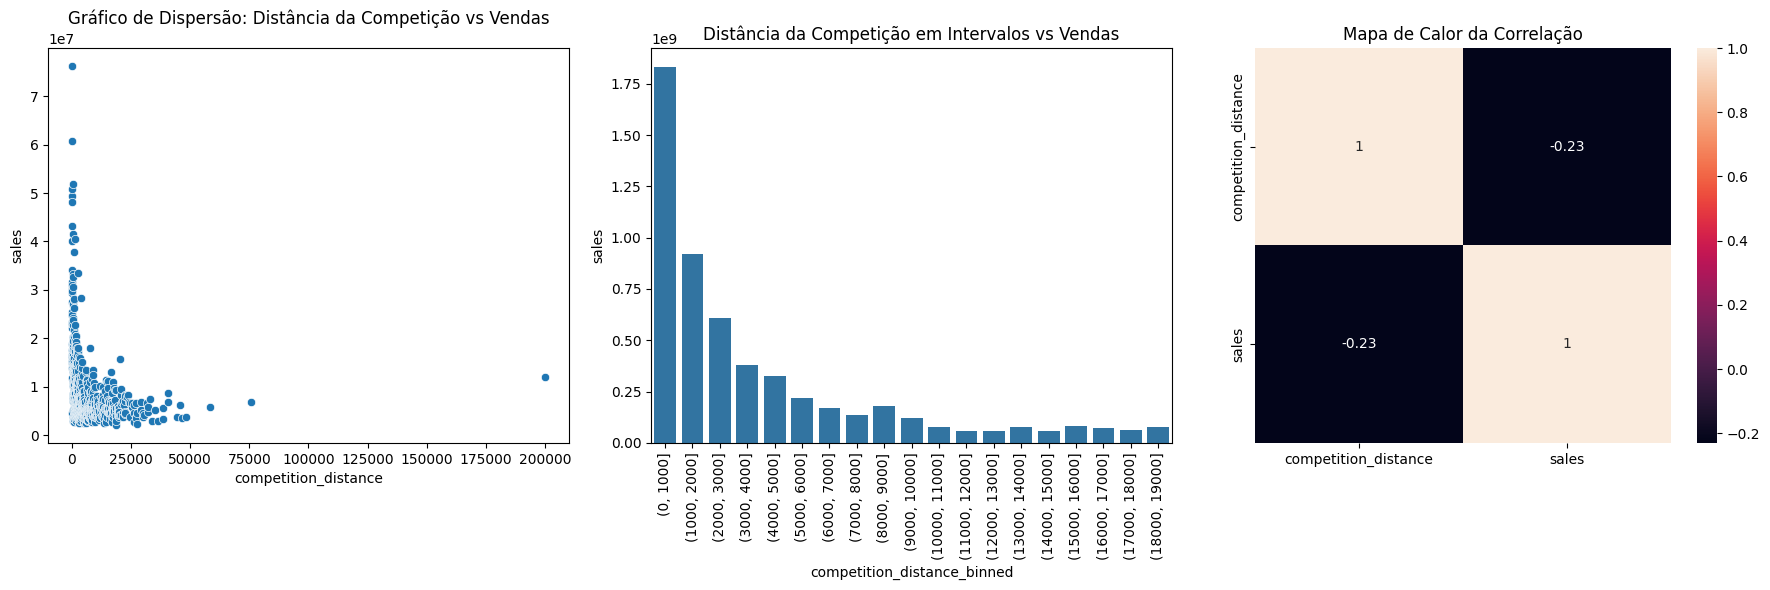

In [29]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title('Gráfico de Dispersão: Distância da Competição vs Vendas')


plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux1['competition_distance_binned'] = aux1['competition_distance_binned'].astype(str)  # Converte intervalos em strings
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

aux2['competition_distance_binned'] = pd.Categorical(aux2['competition_distance_binned'], categories=[str(b) for b in pd.cut(aux1['competition_distance'], bins=bins).cat.categories], ordered=True)

sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.title('Distância da Competição em Intervalos vs Vendas')


plt.subplot(1, 3, 3)
sns.heatmap(aux1[['competition_distance', 'sales']].corr(method='pearson'), annot=True)
plt.title('Mapa de Calor da Correlação')

plt.tight_layout()
plt.show()

In [30]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
367,5460.0,5268860,"(5000, 6000]"
585,18640.0,4869839,"(18000, 19000]"
266,3350.0,14137142,"(3000, 4000]"
534,14160.0,5533037,"(14000, 15000]"


### **3.** Lojas com competidores a mais tempo deveriam vender mais

**FALSA**

<Axes: >

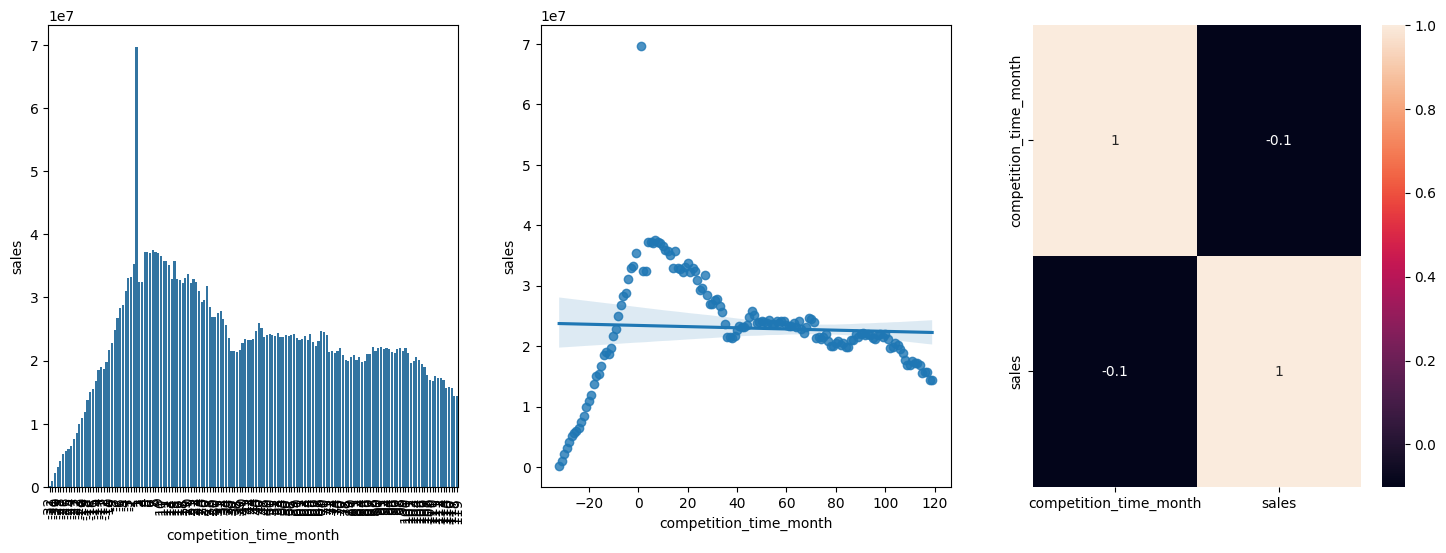

In [31]:
plt.figure(figsize=(18, 6))


plt.subplot(1,3,1)

aux1=df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2=aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month']!=0)]
sns.barplot(x='competition_time_month', y= 'sales', data=aux2)
plt.xticks(rotation=90);


plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y= 'sales', data=aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### **4.** lojas com promoções ativas por mais tempo deveriam vender mais.


**FALSA**

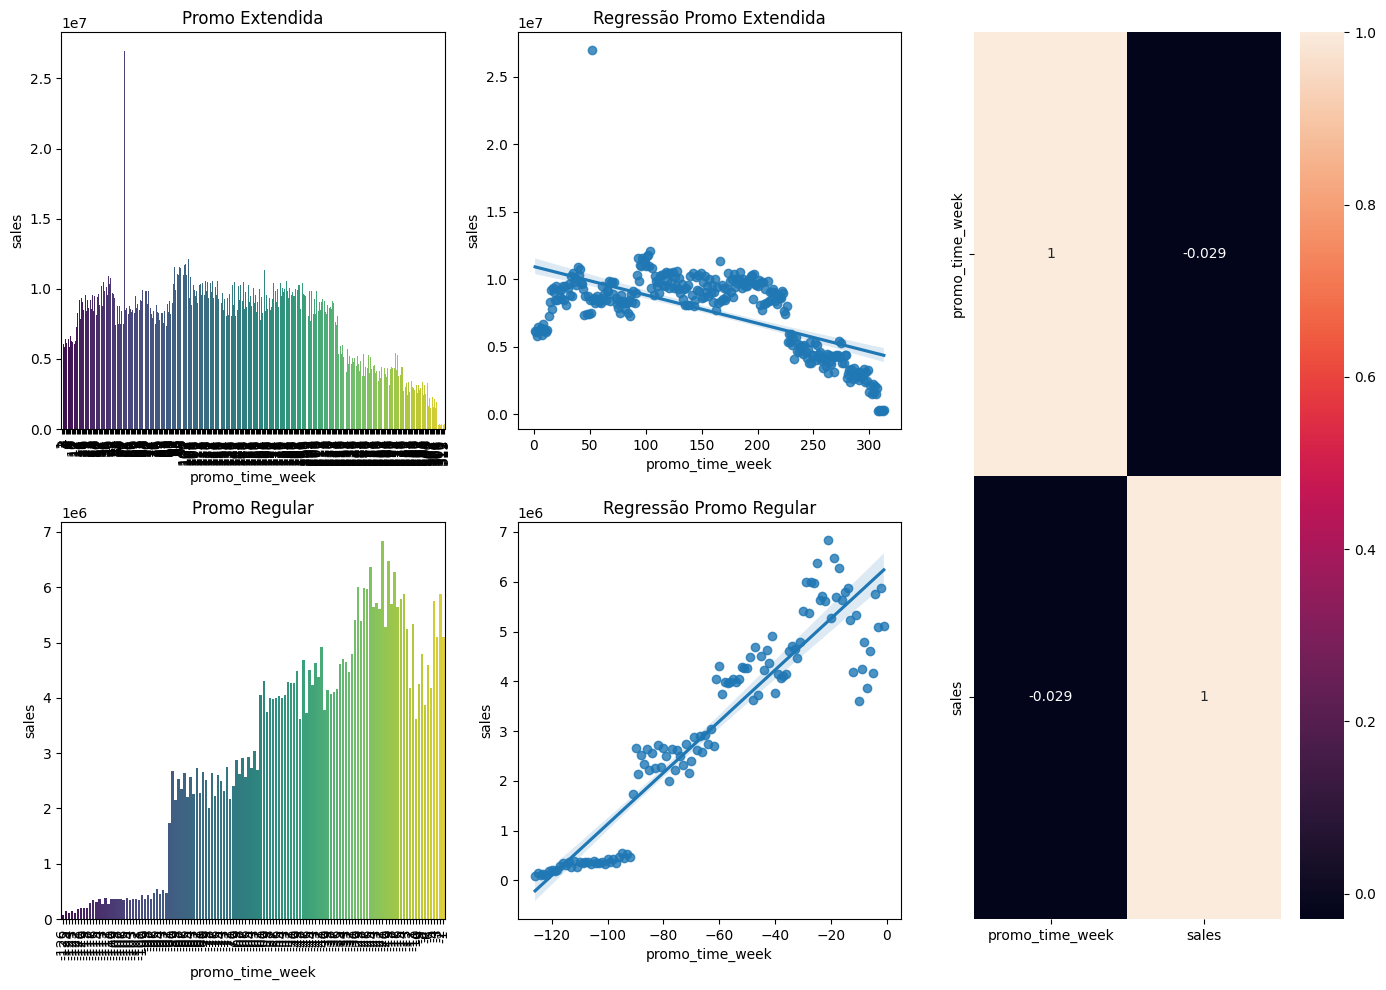

In [32]:
plt.figure(figsize=(14, 10))

grid = GridSpec(2, 3)

aux1=df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2, palette='viridis')
plt.xticks(rotation=90)
plt.title('Promo Extendida')

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Regressão Promo Extendida')

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3, palette='viridis')
plt.xticks(rotation=90)
plt.title('Promo Regular')

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Regressão Promo Regular')

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)



plt.tight_layout()
plt.show()

### **5.** lojas com mais dias de promoção deveriam vender mais.

### **6.** lojas com mais promoções conseuctivas deveriam vender mais.

**FALSA**

In [33]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


In [34]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

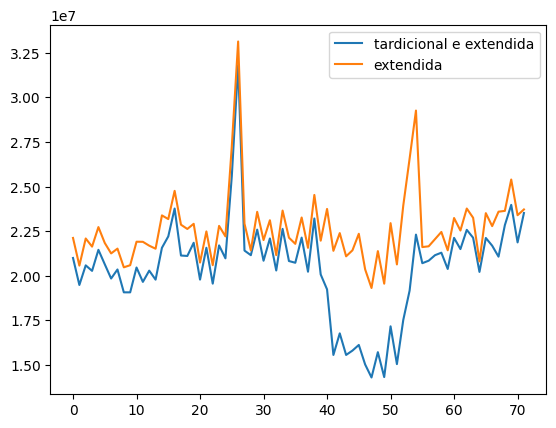

In [35]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)].groupby('year_week')['sales'].sum().reset_index()
ax=aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)].groupby('year_week')['sales'].sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['tardicional e extendida','extendida'])

### **1.** lojas abertas durante o feriado de natal deveriam vender mais.

**FALSA**

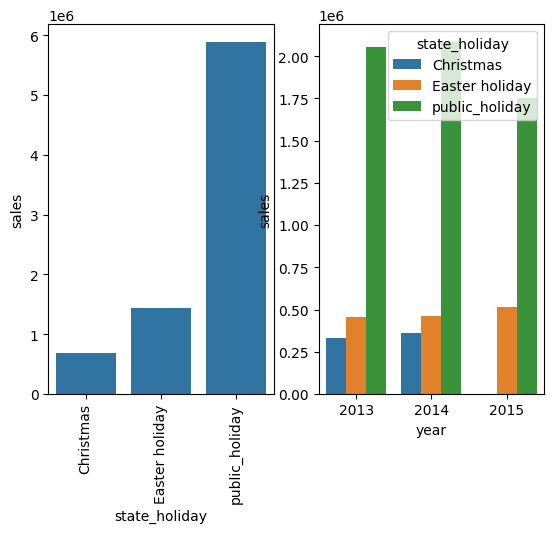

In [36]:
aux=df4[df4['state_holiday']!= 'regular_day']

plt.subplot(1,2,1)
aux1=aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales', data=aux1);
plt.xticks(rotation=90)

plt.subplot(1,2,2)
aux2=aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **2.** lojas deveriam vender mais ao longos dos anos.

**FALSA**

<Axes: >

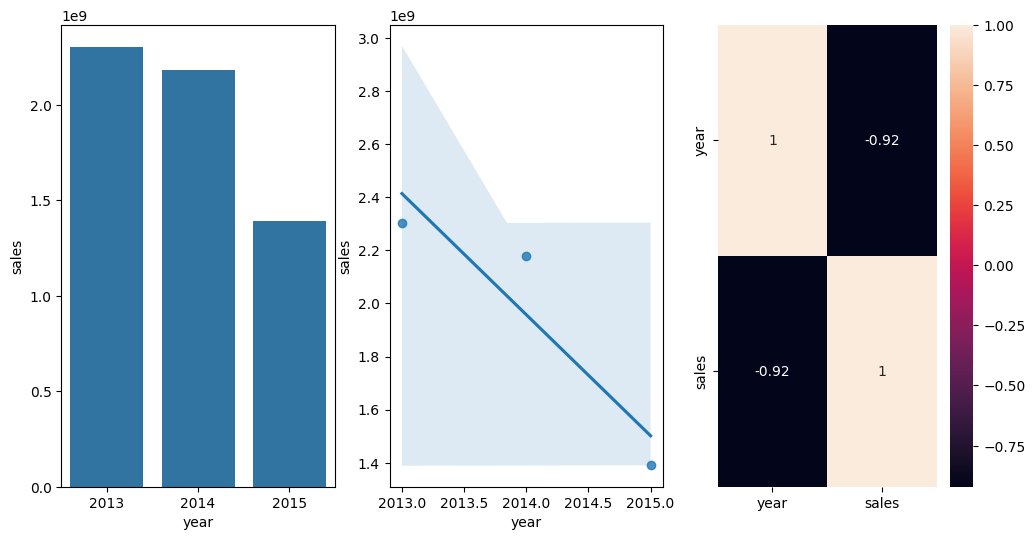

In [37]:
plt.figure(figsize=(12, 6))


aux1=df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### **3.** lojas deveriam vender mais no segundo semestre do ano.

**FALSA**

<Axes: >

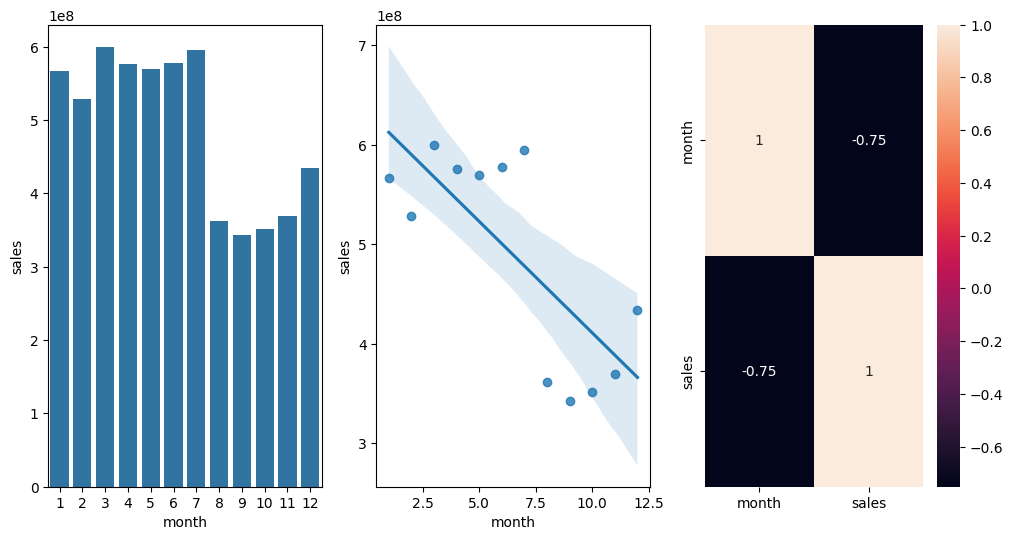

In [38]:
plt.figure(figsize=(12, 6))


aux1=df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### **4.** lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADE**

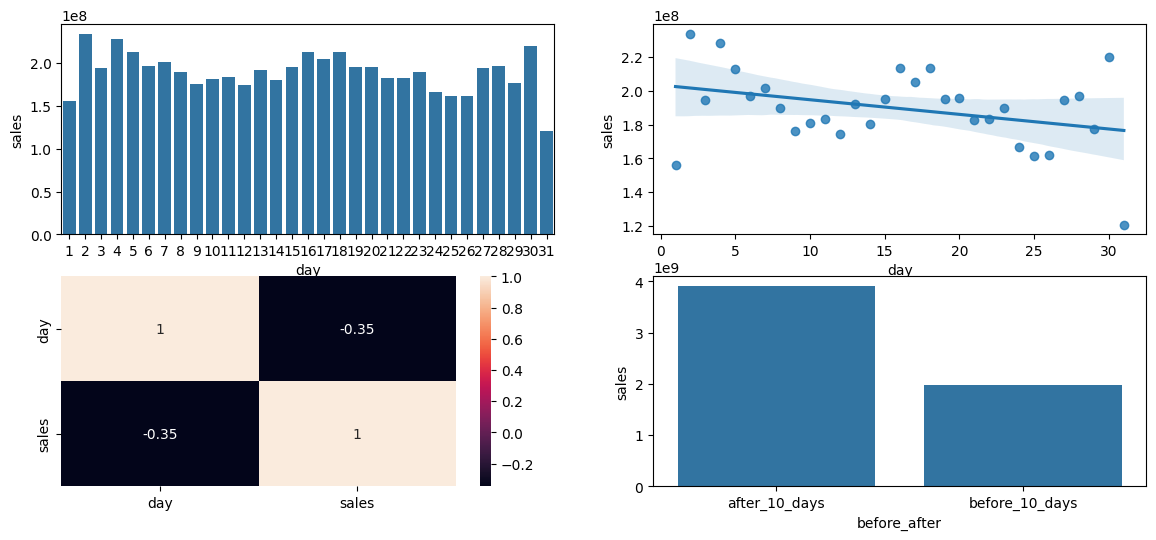

In [39]:
plt.figure(figsize=(14, 6))


aux1=df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

plt.subplot(2,2,4)
aux1['before_after']=aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux2=aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y= 'sales', data=aux2);

### **5.** lojas deveriam vender menos aos finais de semana.

**VERDADE**

<Axes: >

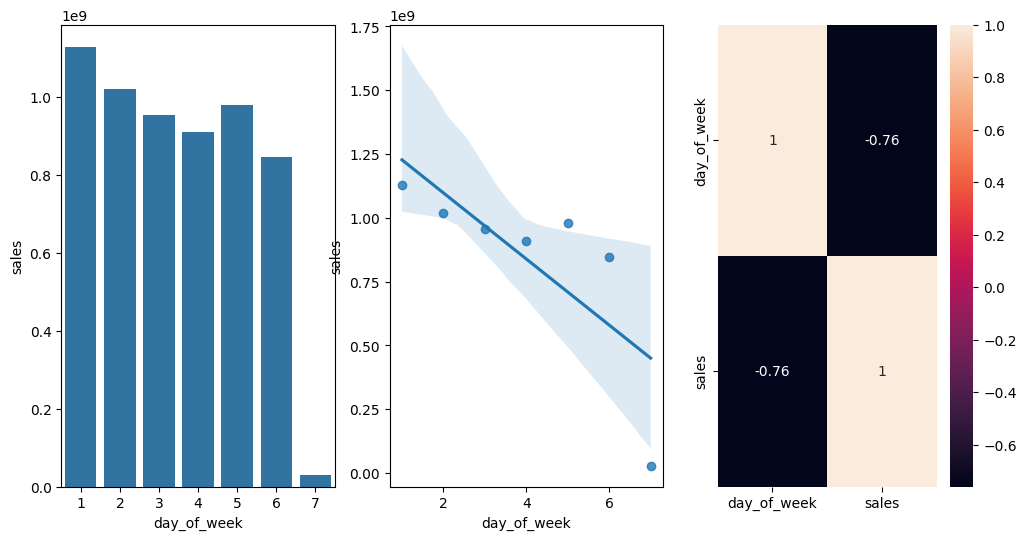

In [40]:
plt.figure(figsize=(12, 6))


aux1=df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

  ### **6.** Lojas deveriam vender menos durante os feriados escolares .

  **verdadeira, porém temos execessões nos meses de férias**

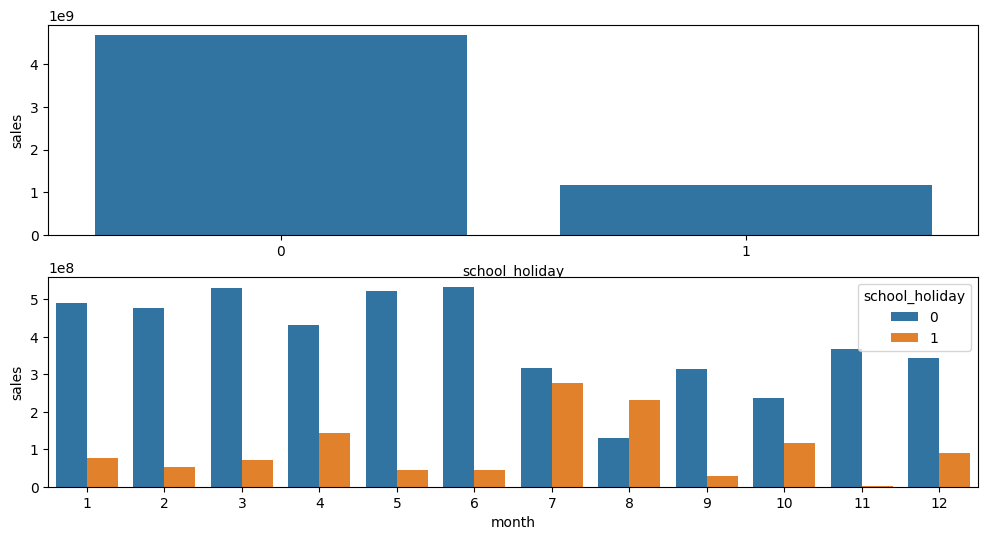

In [41]:
plt.figure(figsize=(12, 6))

aux1=df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales',data=aux1);


aux2=df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales',hue='school_holiday',data=aux2);


## 4.3. ANALISE MULTIVARIADA 

### 4.3.1. Atributos numericos 

<Axes: >

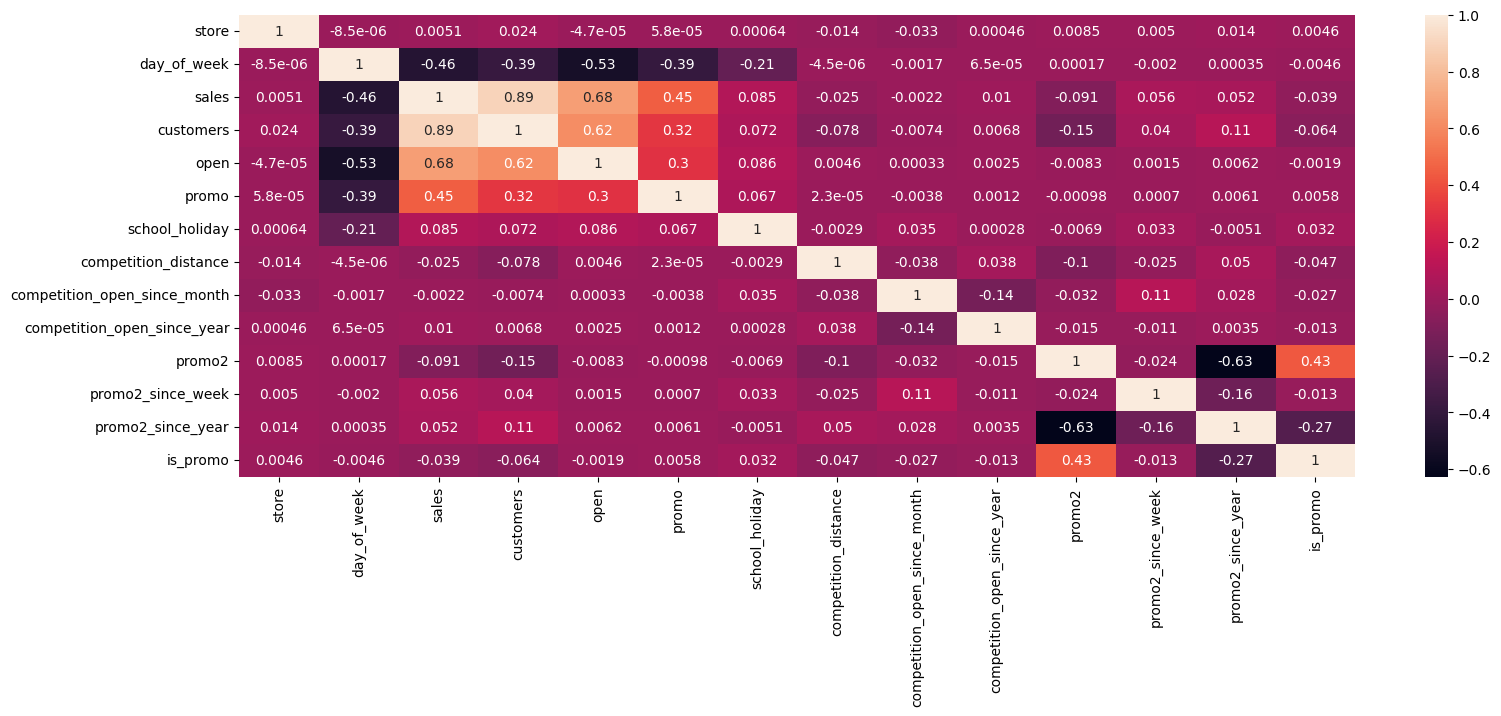

In [42]:
plt.figure(figsize= (18,6))

correlation=atributo_num.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2. Atributos Categoricos 

In [43]:
def cramer_v(x,y):
    cm=pd.crosstab(x, y).values
    n=cm.sum()
    r,k=cm.shape

    chi2=ss.chi2_contingency(cm)[0]
    chi2corr=max(0, chi2-(k-1)*(r-1)/(n-1))
    kcorr= k - (k-1)**2/(n-1)
    rcorr= r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1,rcorr-1)))

In [44]:
a=df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [45]:
a1=cramer_v(a['state_holiday'], a['state_holiday'] )
a2=cramer_v(a['state_holiday'], a['store_type'] )
a3=cramer_v(a['state_holiday'], a['assortment'] )

a4=cramer_v(a['store_type'], a['state_holiday'] )
a5=cramer_v(a['store_type'], a['store_type'] )
a6=cramer_v(a['store_type'], a['assortment'] )

a7=cramer_v(a['assortment'], a['state_holiday'] )
a8=cramer_v(a['assortment'], a['store_type'] )
a9=cramer_v(a['assortment'], a['assortment'] )

d=pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})

d=d.set_index(d.columns)

<Axes: >

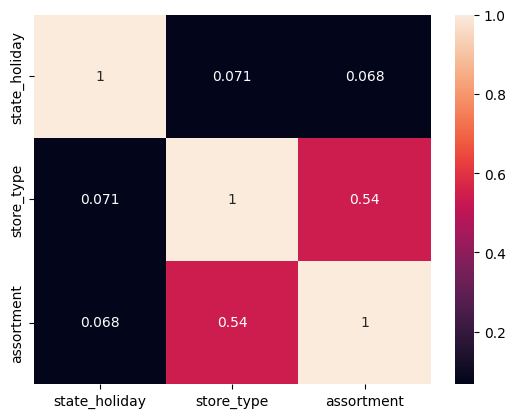

In [46]:
sns.heatmap(d,annot=True)

# 5.0. PASSO 05 - DATA PREPARATION

In [47]:
df5=df4.copy()

## 5.1. NORMALIZAÇÃO

## 5.2. RESCALING

In [48]:
a=df5.select_dtypes(include=['int','float',])

In [49]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


<Axes: ylabel='promo_time_week'>

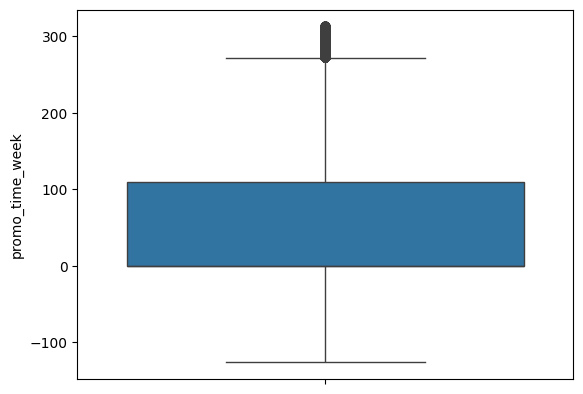

In [50]:
sns.boxplot(df5['promo_time_week'])

In [51]:
rs = RobustScaler()
mms=MinMaxScaler()

#competition distance
df5['competition_distance']=rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

#competition time month
df5['competition_time_month']=rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

#promo time week
df5['promo_time_week']=mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

#year
df5['year']=mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.3. TRANSFORMAÇÃO

### 5.3.1. ENCODING

In [52]:
#one hot encoding
df5=pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

#store Type
le=LabelEncoder()
df5['store_type']=le.fit_transform(df5['store_type'])
pickle.dump(le,open('parameter/store_type_scaler.pkl', 'wb'))

assortment_dict={'basic':1, 'extra':2, 'extended':3}
df5['assortment']=df5['assortment'].map(assortment_dict)

In [53]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_Christmas,state_holiday_Easter holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True


### 5.3.2. RESPONSE VARIABLE TRANSFORMATION

In [54]:
df5['sales']=np.log1p(df5['sales'])

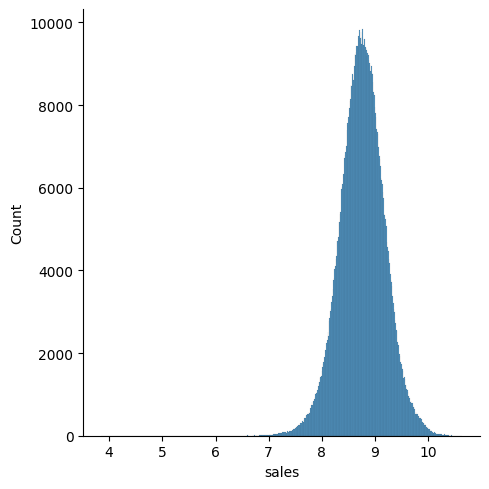

In [55]:
sns.displot(df5['sales'])

### 5.3.3. NATURE TRANSFORMATION

In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_Christmas,state_holiday_Easter holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,False,True
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,False,False,False,True
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,False,False,False,True
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,False,True
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,False,False,False,True


In [57]:
df5['day_of_week_sin']=df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_con']=df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

df5['month_sin']=df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_con']=df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

df5['day_sin']=df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_con']=df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_con']=df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))



In [58]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_con,month_sin,month_con,day_sin,day_con,week_of_year_sin,week_of_year_con
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - FEATURE SELECTION

In [59]:
df6=df5.copy()

## 6.1. SPLIT DATAFRAME INTO TRAINING AND TEST DATASET 

In [60]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_con,month_sin,month_con,day_sin,day_con,week_of_year_sin,week_of_year_con
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [61]:
cols_drop=['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6=df6.drop(cols_drop, axis=1)

In [62]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0]-datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [63]:
#base de dados de treino

X_train=df6[df6['date']<'2015-06-19']
y_train=X_train['sales']

#base de dados de teste
X_test=df6[df6['date']>='2015-06-19']
y_test=X_test['sales']

print('training min date: {}'.format(X_train['date'].min()))
print('training max date: {}'.format(X_train['date'].max()))

print('\ntest min date: {}'.format(X_test['date'].min()))
print('testmax date: {}'.format(X_test['date'].max()))

training min date: 2013-01-01 00:00:00
training max date: 2015-06-18 00:00:00

test min date: 2015-06-19 00:00:00
testmax date: 2015-07-31 00:00:00


## 6.2. BORUTA AS FATURE SELECTOR 

In [64]:
#X_train_n=X_train.drop(['date','sales'],axis=1).values
#y_train_n=y_train.values.ravel()

#rf=RandomForestRegressor(n_jobs=-1)

#boruta=BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_n, y_train_n)

### 6.2.1. BEST FEATURES FROM BORUTA

In [65]:
#cols_selected=boruta.support_.tolist()

#best feactures
#X_train_fs=X_train.drop(['date','sales'],axis=1)
#cols_selected_boruta=X_train_fs.iloc[:,cols_selected].columns.to_list()

#not selected boruta
#cols_not_selected_boruta=np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

## 6.3. MANUAL FEATURE SELECTION

In [66]:
cols_selected_boruta= [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_con',
    'month_con',
    'day_sin',
    'day_con',
    'week_of_year_con']

feat_to_add=['date','sales']

cols_selected_boruta_full=cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [67]:
cols_not_selected_boruta=['is_promo', 'month_sin', 'school_holiday',
       'state_holiday_Christmas', 'state_holiday_Easter holiday',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'week_of_year_sin', 'year']

print(cols_not_selected_boruta)


['is_promo', 'month_sin', 'school_holiday', 'state_holiday_Christmas', 'state_holiday_Easter holiday', 'state_holiday_public_holiday', 'state_holiday_regular_day', 'week_of_year_sin', 'year']


# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [68]:
x_train=X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[ cols_selected_boruta_full ]

## 7.1. AVERAGE MODEL

In [69]:
def mean_absolute_percentage_error(y,yaht):
    return np.mean(np.abs((y-yaht)/y))

def ml_error(model_name, y, yhat):
    mae= mean_absolute_error(y,yhat)
    mape=mean_absolute_percentage_error(y,yhat)
    rmse=np.sqrt(mean_squared_error(y,yhat))

    return pd.DataFrame ( {'Model Name' : model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE': rmse},index=[0])

In [70]:
aux1=x_test.copy()
aux1['sales']=y_test.copy()

aux2=aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1=pd.merge(aux1,aux2, how='left', on='store')
yhat_baseline=aux1['predictions']

#perfomance

baseline_result=ml_error('average_moedel',np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,average_moedel,1354.800353,0.455051,1835.135542


## 7.2. LINEAR REGRESSION MODEL

In [71]:
#model
lr=LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr=lr.predict(x_test)

#perfomance
lr_result=ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1869.922218,0.295044,2667.521087


### 7.2.1. LINEAR REGRESSION MODEL - CROSS VALIDATION

In [72]:
lr_result_cv=cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,MODEL NAME,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2079.28+/-303.04,0.3+/-0.02,2961.07+/-473.32


## 7.3. LINEAR REGRESSION REGULARIZED MODEL - LASSO

In [73]:
#model
lrr=Lasso(alpha=0.01).fit(x_train,y_train)

#prediction
yhat_lrr=lrr.predict(x_test)

#perfomance
lrr_result=ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.194993,0.289872,2741.003248


### 7.3.1.  LASSO - CROSS VALIDATION

In [74]:
lrr_result_cv=cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,MODEL NAME,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.98+/-342.05,0.29+/-0.01,3059.41+/-504.65


## 7.4. RANDOM FOREST REGRESSOR

In [75]:
#model
rf=RandomForestRegressor(n_estimators=100, n_jobs=1, random_state=42).fit(x_train,y_train)

#prediction
yhat_rf=rf.predict(x_test)

#perfomance
rf_result=ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,731.144856,0.108726,1075.68026


### 7.4.1. RANDOM FOREST REGRESSOR - CROSS VALIDATION

In [76]:
#rf_result_cv=cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
#rf_result_cv

## 7.5.XGBOOST REGRESSOR

In [77]:
#model
#model_xgb=xgb.XGBRegressor( objective='reg:squarederror',
                            #n_estimators=100, 
                            #eta=0.01,
                            #max_depth=10,
                            #subsample=0.7,
                            #).fit(x_train, y_train)


#prediction
#yhat_xgb=model_xgb.predict(x_test)

#perfomance
#xgb_result=ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
#xgb_result

### 7.5.1. XGBOOST REGRESSOR - CROSS VALIDATION

In [78]:
#xgb_result_cv=cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#xgb_result_cv

## 7.6. COMPARE MODELS PERFOMANCE

### 7.6.1. SINGLE PERFOMANCE

In [79]:
#modelling_result=pd.concat([baseline_result,lr_result, lrr_result, rf_result, xgb_result])
#modelling_result.sort_values('RMSE')

### 7.6.2. REAL PERFOMANCE - CROSS VALIDATION

In [80]:
#modelling_result_cv=pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv

In [81]:
#x_training=X_train[cols_selected_boruta_full]

In [82]:
#model=Lasso(alpha=0.01)

#a=cross_validation(x_training, 5, 'Lasso', model, verbose=True)

In [83]:
#a

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. RANDOM SEARCH 

In [84]:
#param={
       #'n_estimators': [1500,1700,2500,3000,3500],
       #'eta': [0.01,0.03],
       #'max_depth': [3,5,9],
       #'subsample': [0.1,0.5,0.7],
       #'colsample_bytree': [0.3,0.7,0.9],
       #'min_child_weight': [3,8,15]}

#MAX_EVAL=10

In [85]:
#final_result=pd.DataFrame()

#for i in range(MAX_EVAL):
    #chosse values for parameters randomly
    #hp={k: random.sample(v,1)[0] for k, v in param.items()}
    #print(hp)

    #model
    #model_xgb=xgb.XGBRegressor( objective='reg:squarederror',
                                #n_estimators=hp['n_estimators'], 
                                #eta=hp['eta'],
                                #max_depth=hp['max_depth'],
                                #subsample=hp['subsample'],
                                #colsample_bytee=hp['colsample_bytree'],
                                #min_child_weight=hp['min_child_weight'])


    #perfomance
    #result=cross_validation(x_training,2,'XGoost Regressor', model_xgb,verbose=False)
    #final_result=pd.concat([final_result,result])

#final_result

## 8.2. FINAL MODEL 

In [86]:
param_tuned={
       'n_estimators': 1700,
       'eta':0.03,
       'max_depth': 9,
       'subsample':0.7,
       'colsample_bytree':0.7,
       'min_child_weight':15}




In [87]:
#model
model_xgb_tuned=xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=param_tuned['n_estimators'], 
                                  eta=param_tuned['eta'],
                                  max_depth=param_tuned['max_depth'],
                                  subsample=param_tuned['subsample'],
                                  colsample_bytee=param_tuned['colsample_bytree'],
                                  min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned=model_xgb_tuned.predict(x_test)

#perfomance
xbg_result_tuned=ml_error('XGoost Regressor', np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xbg_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGoost Regressor,678.250788,0.09868,985.204374


In [88]:
np.expm1(y_test).min()

np.float64(569.0000000000002)

In [89]:
np.expm1(y_test).max()

np.float64(41550.99999999998)

In [90]:
np.expm1(y_test).max()-np.expm1(y_test).min()

np.float64(40981.99999999998)

In [91]:
np.expm1(y_test).mean()

np.float64(6995.162576094309)

In [92]:
956/6695

0.14279312920089618

In [93]:
def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)

In [94]:
mpe=mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

np.float64(-0.0071847026477077245)

# 9.0. PASSO 09 - TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [95]:
df9=X_test[cols_selected_boruta_full]

#rescale
df9['sales']=np.expm1(df9['sales'])
df9['predictions']=np.expm1(yhat_xgb_tuned)

## 9.1. BUSINESS PERFOMANCE

In [96]:
# sum of predictions 

df91= df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE

df9_aux1=df9[['store','sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2=df9[['store','sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#merge

df9_aux3=pd.merge(df9_aux1,df9_aux2, how='inner',on='store')
df92=pd.merge(df91,df9_aux3, how='inner', on='store')

#scenarios
df92['worst_scenario']=df92['predictions']-df92['MAE']
df92['best_scenario']=df92['predictions']+df92['MAE']

#order columns
df92=df92[['store','predictions','worst_scenario', 'best_scenario','MAE','MAPE']]

In [97]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
846,847,248502.765625,247872.409246,249133.122004,630.356379,0.100022
230,231,186157.484375,185642.283573,186672.685177,515.200802,0.109469
15,16,293239.437500,292577.124353,293901.750647,662.313147,0.084534
242,243,257271.875000,256603.472023,257940.277977,668.402977,0.100060


In [98]:
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106914.25000,103553.674573,110274.825427,3360.575427,0.592038
908,909,233558.50000,225958.053711,241158.946289,7600.446289,0.509813
594,595,363572.46875,359095.697371,368049.240129,4476.771379,0.307147
875,876,207270.46875,203421.081989,211119.855511,3849.386761,0.289625
721,722,350267.09375,348348.956437,352185.231063,1918.137313,0.260802


<Axes: xlabel='store', ylabel='MAPE'>

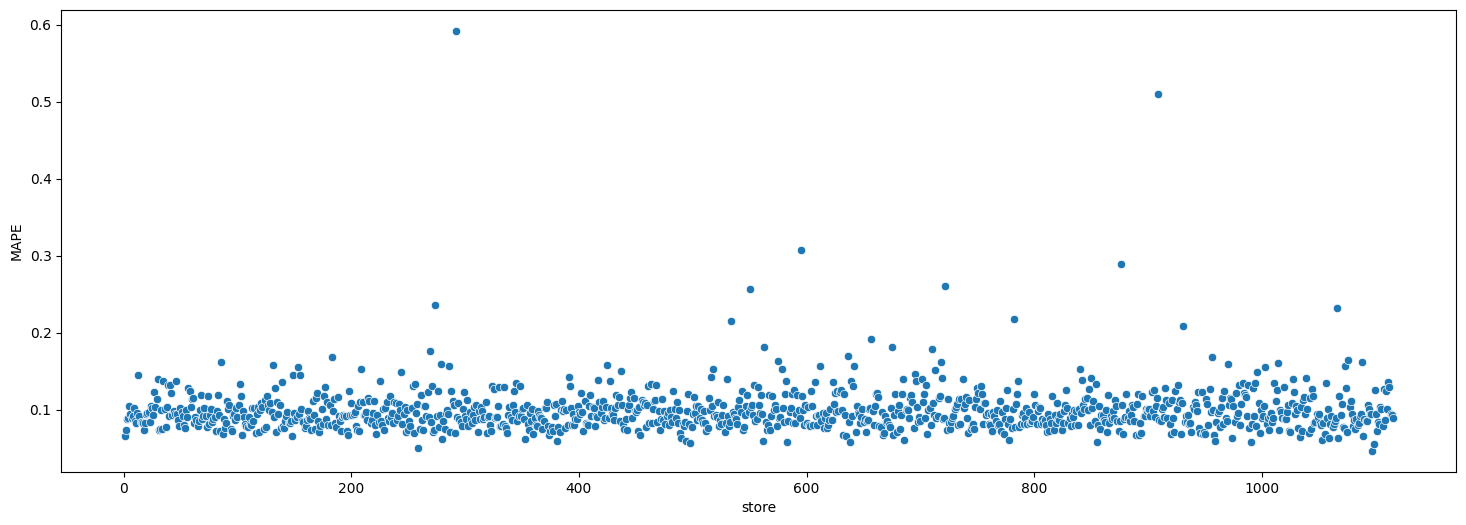

In [99]:
plt.figure(figsize=(18,6))

sns.scatterplot(x='store',y='MAPE',data=df92)

## 9.2. TOTAL PERFOMANCE 

In [100]:
df93=df92[['predictions','worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0 : 'values'})
df93['values']=df93['values'].map('R${:,.2f}'.format)
df93

,Scenario,values
0,predictions,"R$286,875,616.00"
1,worst_scenario,"R$286,115,257.97"
2,best_scenario,"R$287,635,989.79"


## 9.3. MACHINE LEARNING PERFOMANCE

In [101]:
df9['error'] = df9['sales']- df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

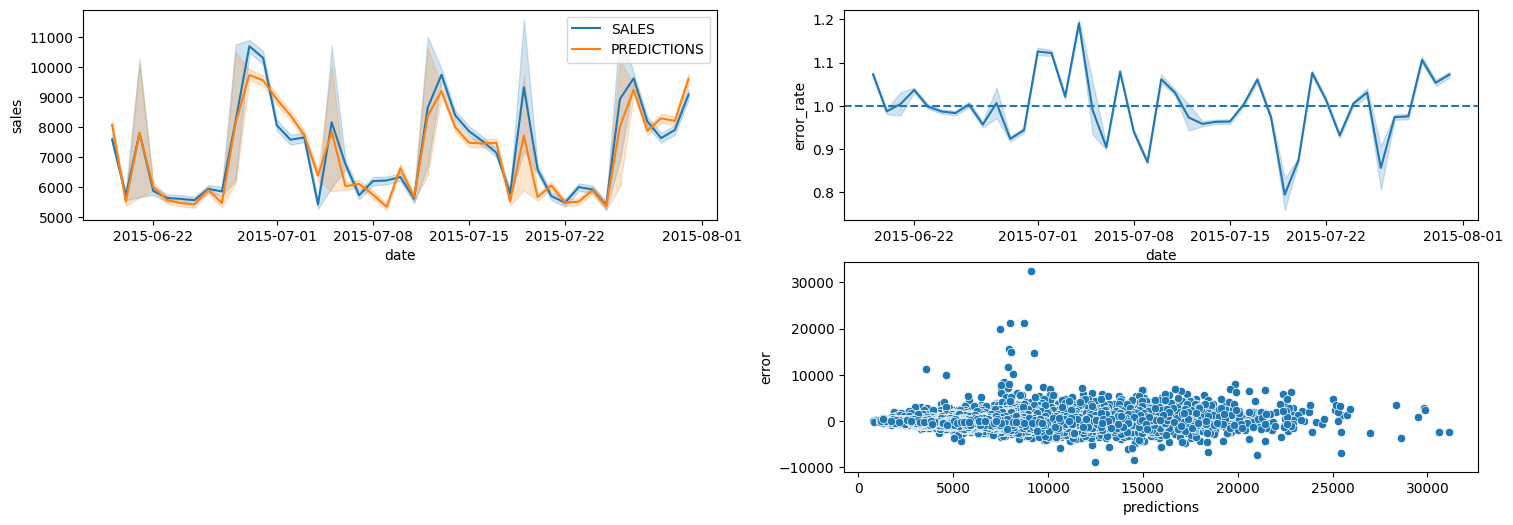

In [102]:
plt.figure(figsize=(18,6))

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

#plt.subplot( 2, 2, 3 )
#sns.displot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(x=df9['predictions'], y=df9['error'])

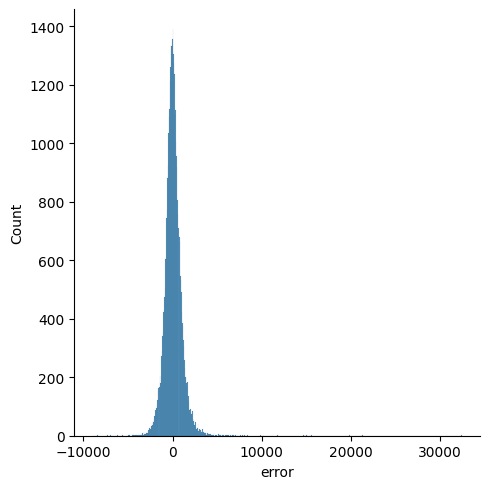

In [103]:
sns.displot( df9['error'] )

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

## 10.1. ROSSMAN CLASS

In [104]:
class Rossmann (object):
    def __init__(self):
        self.competition_distance_scaler  =pickle.load( open('parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler=pickle.load(open('parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler       =pickle.load(open('parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                  =pickle.load(open('parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler            =pickle.load(open('parameter/store_type_scaler.pkl', 'rb'))
    
    def data_cleaning(self,df1):
        cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

        snakecase= lambda x: inflection.underscore(x)

        cols_new=list(map(snakecase,cols_old))

        #rename

        df1.columns=cols_new

        #1.3. Data Types
        df1['date']=pd.to_datetime(df1['date'])

        ##1.5. Fillout NA
        #competition_distance
        df1['competition_distance']=df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month 
        df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

                                    
        #promo2_since_week
        df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year
        df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval 
        month_map={1:'Jan', 2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

        df1['promo_interval'].fillna(0,inplace=True)
        df1['month_map']=df1['date'].dt.month.map(month_map)

        df1['is_promo']=df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


        #1.6. Change Types
        #competition
        df1['competition_open_since_month']=df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year']=df1['competition_open_since_year'].astype(int)

        #promo2
        df1['promo2_since_week']=df1['promo2_since_week'].astype(int)
        df1['promo2_since_year']=df1['promo2_since_year'].astype(int)

        return df1


    def feature_engineering(self,df2):

        #feature engineering    
        #year
        df2['year']=df2['date'].dt.year

        #month
        df2['month']=df2['date'].dt.month

        #day 
        df2['day']=df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week 
        df2['year_week']=df2['date'].dt.strftime('%Y-%W')

        #competition since 
        df2['competition_since']=df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
        df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(lambda x:x.days).astype(int)

        # promo since 
        df2['promo_since']=df2['promo2_since_year'].astype(str)+'-' + df2['promo2_since_week'].astype(str)

        df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w')-datetime.timedelta(days=7))

        df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment']=df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

        #state holiday 
        df2['state_holiday']=df2['state_holiday'].apply (lambda x: 'public_holiday' if x=='a' else 'Easter holiday' if x=='b' else 'Christmas' if x=='c' else 'regular_day')

        #filtragem de variaveis 
        #filtragem de linhas 
        df2=df2[(df2['open']!=0 ) & (df2['sales'] >0)]

        #filtragem de colunas
        cols_drop = ['customers','open','promo_interval', 'month_map']
        df2=df2.drop(cols_drop, axis=1)

        return df2


    def data_preparation(self,df5):
        #rescaling
        #competition distance
        df5['competition_distance']=self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition time month
        df5['competition_time_month']=self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        #promo time week
        df5['promo_time_week']=self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        #year
        df5['year']=self.year_scaler.fit_transform(df5[['year']].values)

        #one hot encoding
        df5=pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        #store Type
        le=LabelEncoder()
        df5['store_type']=self.store_type_scaler.fit_transform(df5['store_type'])

        #ordinal encoding
        assortment_dict={'basic':1, 'extra':2, 'extended':3}
        df5['assortment']=df5['assortment'].map(assortment_dict)


        df5['day_of_week_sin']=df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
        df5['day_of_week_con']=df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

        df5['month_sin']=df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        df5['month_con']=df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

        df5['day_sin']=df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
        df5['day_con']=df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

        df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
        df5['week_of_year_con']=df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

        cols_selected=['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
        'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week',
        'day_of_week_sin','day_of_week_con','month_con','day_sin','day_con','week_of_year_con']

        return df5[cols_selected]

KeyError: "None of [Index(['state_holiday'], dtype='object')] are in the [columns]"

## 10.2. API HANDLER

## 10.3. API TESTER